# Covid-19 analysis updated
This Python3 notebook is based on the original [Pharo Smalltalk version](https://github.com/olekscode/CovidAnalysis) by Oleksandr Zaitsev and is an update of the [August 2020 version](CovidAnalysis.ipynb). <br> The dataset for this Covid-19 analysis is publicly available and from 14 December 2020 published weekly on Thursdays. Where appropriate some code extensions have been added to view the supplied data from a different angle.

#### Disclaimer 
January 2021. To prevent inappropriate conclusions drawn on this highly actual subject:
* As a Data Science excercise this Covid-19 analysis is purely intended for educational purposes.
* The outcome of the code cells in this notebook should be regarded as the *technical* result of the code and not be interpreted otherwise.
* I have no opinion on the dataset provided nor am I responsible for possible misinterpretation of the outcome

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
import urllib.request
import pickle
import requests
import datetime

### Download latest COVID-19 data
Download the latest COVID-19 data from the [European Centre for Disease Prevention](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide).

In [2]:
def dataCsvURL():
    return 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'

In [3]:
def dataDirectory():
    return 'data/'

In [4]:
def dataCsvFile():
    return dataDirectory() + 'covidDataWeekly.csv'

In [6]:
#Let's give it a try and save to CSV file
covidFile = requests.get(dataCsvURL())
open(dataCsvFile(), 'wb').write(covidFile.content)

666179

### Read and clean data
Now read the data from the CSV file into a dataframe using pandas. Clean up to show the relevant columns.

In [7]:
def columnsToDisplay():
    return ["dateRep", "cases_weekly", "deaths_weekly", "countriesAndTerritories","popData2019"]

In [8]:
def columnsRenameDict():
    return {'dateRep':'date', 'countriesAndTerritories':'country', 'popData2019':'population' }

In [9]:
# Change date format to DD-MONTH-YYYY
# Convert population to integer. Caution: astype(int) gives error "Cannot convert non-finite values (NA or inf) to integer"
def preProcessing(df):
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df['date'] = df['date'].dt.strftime("%d %B %Y")
    df['population'] = df['population'].astype('Int64')

In [10]:
#df = pd.read_csv(dataCsvFile())
df = pd.read_csv(dataCsvFile(), usecols=columnsToDisplay())
df.rename(columns=columnsRenameDict(), inplace=True)
preProcessing(df)
df.head(20)


,date,cases_weekly,deaths_weekly,country,population
0,01 February 2021,267,16,Afghanistan,38041757
1,25 January 2021,713,43,Afghanistan,38041757
2,18 January 2021,557,45,Afghanistan,38041757
3,11 January 2021,675,71,Afghanistan,38041757
4,04 January 2021,902,60,Afghanistan,38041757
5,28 December 2020,1994,88,Afghanistan,38041757
6,21 December 2020,740,111,Afghanistan,38041757
7,14 December 2020,1757,71,Afghanistan,38041757
8,07 December 2020,1672,137,Afghanistan,38041757
9,30 November 2020,1073,68,Afghanistan,38041757


#### One country
The core of western civilization and a popular holiday destination:

In [11]:
#df[df.country=='Greece'].head() identical to:
df.query("country == 'Greece'").head()

,date,cases_weekly,deaths_weekly,country,population
3828,01 February 2021,4977,150,Greece,10724599
3829,25 January 2021,3373,177,Greece,10724599
3830,18 January 2021,3869,206,Greece,10724599
3831,11 January 2021,4639,306,Greece,10724599
3832,04 January 2021,4168,285,Greece,10724599


### Top 10 countries of reported cases  (in numbers)
This is an aggregate action on the dataframe. As a beginner in Data science and Pandas I find it cumbersome to get these top 10 countries of reported cases. IMO **Pharo's Smalltalk** solution below is much cleaner and easier to understand.

```
(df group: 'cases' by: 'country' aggregateUsing: #sum)
	sortDescending
	head: 10.
```

To find the 10 countries having the least reported cases simply replace `head` by `tail`.

In [12]:
casesPerCountry = df.groupby('country').sum()[['cases_weekly']]
sortedCasesPerCountry = casesPerCountry.sort_values(by=['cases_weekly'], ascending=False)
sortedCasesPerCountry.head(10)

,cases_weekly
country,
United_States_of_America,26321125
India,10757610
Brazil,9229322
Russia,3868087
United_Kingdom,3817176
France,3197114
Spain,2822805
Italy,2553032
Turkey,2477463


### Top 10 countries of reported cases  (relative population)
Another approach is to collect the number of cases in a country relative to the population.

In [13]:
# Find 10 countries with relatively highest cases
populationPerCountry = df.groupby('country').mean()[['population']]
populationPerCountry['cases weekly (%)']=casesPerCountry['cases_weekly'] / populationPerCountry['population'] * 100
populationPerCountry.sort_values(by=['cases weekly (%)'], ascending=False).head(10)

,population,cases weekly (%)
country,,
Andorra,76177,13.044620
Gibraltar,33706,12.205542
Montenegro,622182,9.910123
Czechia,10649800,9.270869
San_Marino,34453,8.780077
Luxembourg,613894,8.253705
Slovenia,2080908,8.000017
United_States_of_America,329064917,7.998764
Israel,8519373,7.585969


### Top 10 countries of reported deaths (in numbers)
To find the 10 countries having the least reported Covid-19 deaths (cumulative) simply replace `head` by `tail`.


In [14]:
casesPerCountry = df.groupby('country').sum()[['deaths_weekly']]
sortedCasesPerCountry = casesPerCountry.sort_values(by=['deaths_weekly'], ascending=False)
sortedCasesPerCountry.head(10)

,deaths_weekly
country,
United_States_of_America,443355
Brazil,225099
Mexico,159100
India,154392
United_Kingdom,106158
Italy,88516
France,76057
Russia,73619
Spain,59081


### Top 10 countries of reported deaths  (relative population)
Another approach is to collect the number of deaths in a country relative to the population.

In [15]:
# Find 10 countries with relatively highest deaths
populationPerCountry = df.groupby('country').mean()[['population']]
populationPerCountry['deaths weekly (%)']=casesPerCountry['deaths_weekly'] / populationPerCountry['population'] * 100
populationPerCountry.sort_values(by=['deaths weekly (%)'], ascending=False).head(10)

,population,deaths weekly (%)
country,,
Gibraltar,33706,0.228446
San_Marino,34453,0.194468
Belgium,11455519,0.184496
Slovenia,2080908,0.180306
United_Kingdom,66647112,0.159284
Czechia,10649800,0.153918
Italy,60359546,0.146648
Bosnia_and_Herzegovina,3300998,0.143108
North_Macedonia,2077132,0.137449


### Covid-19 spread in The Netherlands

In [16]:
df_country = df[df.country=='Netherlands']
relevant_columns = ['date', 'cases_weekly', 'deaths_weekly']
covid_df_country = df_country[relevant_columns]
covid_df_country.head(10)

,date,cases_weekly,deaths_weekly
6765,01 February 2021,28671,445
6766,25 January 2021,35590,522
6767,18 January 2021,38967,645
6768,11 January 2021,57026,799
6769,04 January 2021,50699,570
6770,28 December 2020,80594,551
6771,21 December 2020,76154,443
6772,14 December 2020,56193,360
6773,07 December 2020,38280,338
6774,30 November 2020,34213,457


### Max weekly cases in The Netherlands
Find the week when most cases were reported

In [17]:
maxWeeklyCases = covid_df_country['cases_weekly'].max()
print('Max weekly cases ', 'Netherlands', ' ' , maxWeeklyCases)
covid_df_country[(covid_df_country.cases_weekly==maxWeeklyCases)]

Max weekly cases  Netherlands   80594


,date,cases_weekly,deaths_weekly
6770,28 December 2020,80594,551


### Max weekly deaths in The Netherlands
Find the week when most deaths were reported

In [18]:
maxWeeklyDeaths = covid_df_country['deaths_weekly'].max()
print('Max weekly deaths ', 'Netherlands', ' ' , maxWeeklyDeaths)
covid_df_country[(covid_df_country.deaths_weekly==maxWeeklyDeaths)]

Max weekly deaths  Netherlands   995


,date,cases_weekly,deaths_weekly
6808,06 April 2020,6985,995


### Cumulative sum of cases and deaths
To find the total number of reported cases and deaths up to a date in the Netherlands

In [19]:
covid_df_country['cumulativeCases']=covid_df_country.loc[::-1, 'cases_weekly'].cumsum(axis = 0)[::-1]
covid_df_country['cumulativeDeaths']=covid_df_country.loc[::-1, 'deaths_weekly'].cumsum(axis = 0)[::-1]
covid_df_country.head(10)

<ipython-input-19-a615f20f42ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_country['cumulativeCases']=covid_df_country.loc[::-1, 'cases_weekly'].cumsum(axis = 0)[::-1]


,date,cases_weekly,deaths_weekly,cumulativeCases,cumulativeDeaths
6765,01 February 2021,28671,445,980447,14009
6766,25 January 2021,35590,522,951776,13564
6767,18 January 2021,38967,645,916186,13042
6768,11 January 2021,57026,799,877219,12397
6769,04 January 2021,50699,570,820193,11598
6770,28 December 2020,80594,551,769494,11028
6771,21 December 2020,76154,443,688900,10477
6772,14 December 2020,56193,360,612746,10034
6773,07 December 2020,38280,338,556553,9674
6774,30 November 2020,34213,457,518273,9336


### Reported cases and deaths in the Netherlands
How is Covid-19 moving in time? This plot merely prints the weekly figures. The whereabouts of the data should be given before any conclusion may be drawn. E.g. consider the fact that the test capacity is now considerably higher than after the outbreak of the virus and has an important impact on the number of reported contaminations. However the number of confirmed deaths might be a more reliable indicator.

Text(0, 0.5, 'Weekly Count')

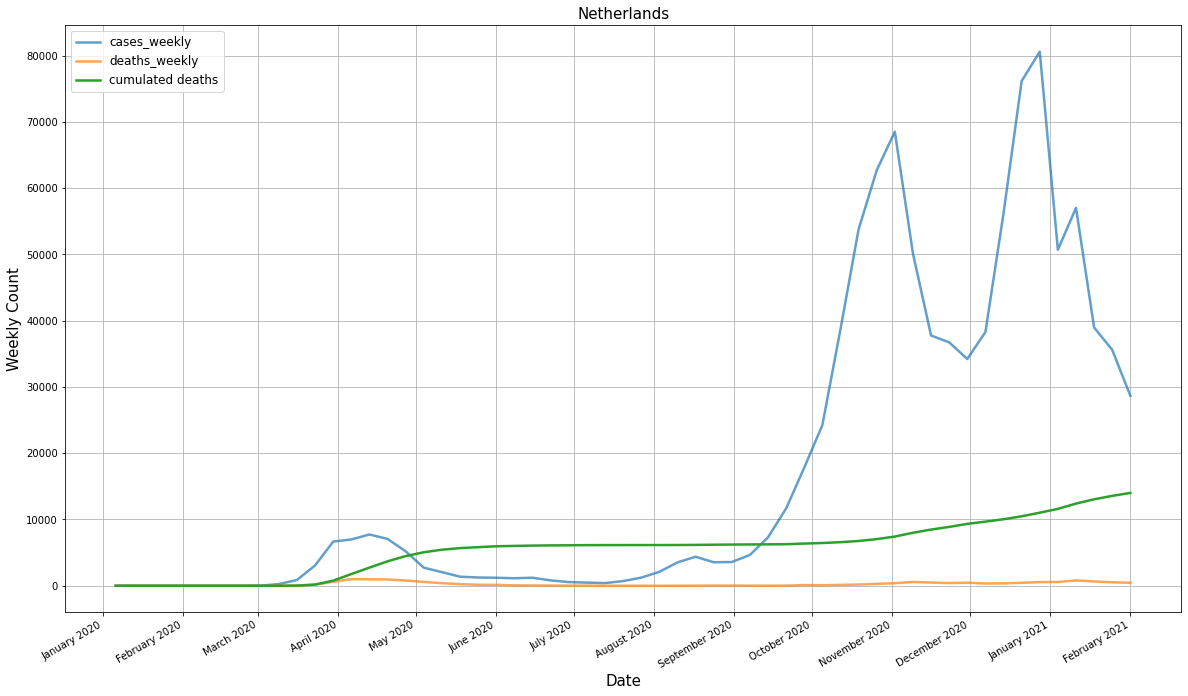

In [20]:
plt.figure(figsize=(20,12))
for i in ['cases_weekly', 'deaths_weekly']:    
    x = [datetime.datetime.strptime(d,'%d %B %Y') for d in covid_df_country.date.values] #convert strings to dates
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    plt.plot(x,covid_df_country[i], alpha=0.7, label=i, linewidth='2.5')
    plt.gcf().autofmt_xdate()

plt.plot (x, covid_df_country['cumulativeDeaths'], label='cumulated deaths', linewidth='2.5')
plt.legend(loc="upper left", prop={'size': 12})
plt.grid()
plt.title('Netherlands', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Weekly Count', fontsize=15)

### Plot data several countries
For some European countries the weekly reported deaths are plotted in absolute numbers, relative to the population and cumulated. Justification country choice:
* Italy => first European country hit by Covid-19
* United_Kingdom => British variant of Covid-19
* Austria and Poland => comparatively small effect in 1st wave
* Belgium => comparatively high effect in 1st wave
* Netherlands => where I live

Change the `countries` list to show other countries.

In [21]:
countries = ['Austria', 'Belgium', 'Italy', 'Netherlands', 'Poland', 'United_Kingdom']
relevant_columns = ['date', 'deaths_weekly',  'country', 'population']
df_countries = [df[df.country==country] for country in countries]
covid_df_countries = [df_country[relevant_columns] for df_country in df_countries]

#### Absolute numbers

Text(0, 0.5, 'Count')

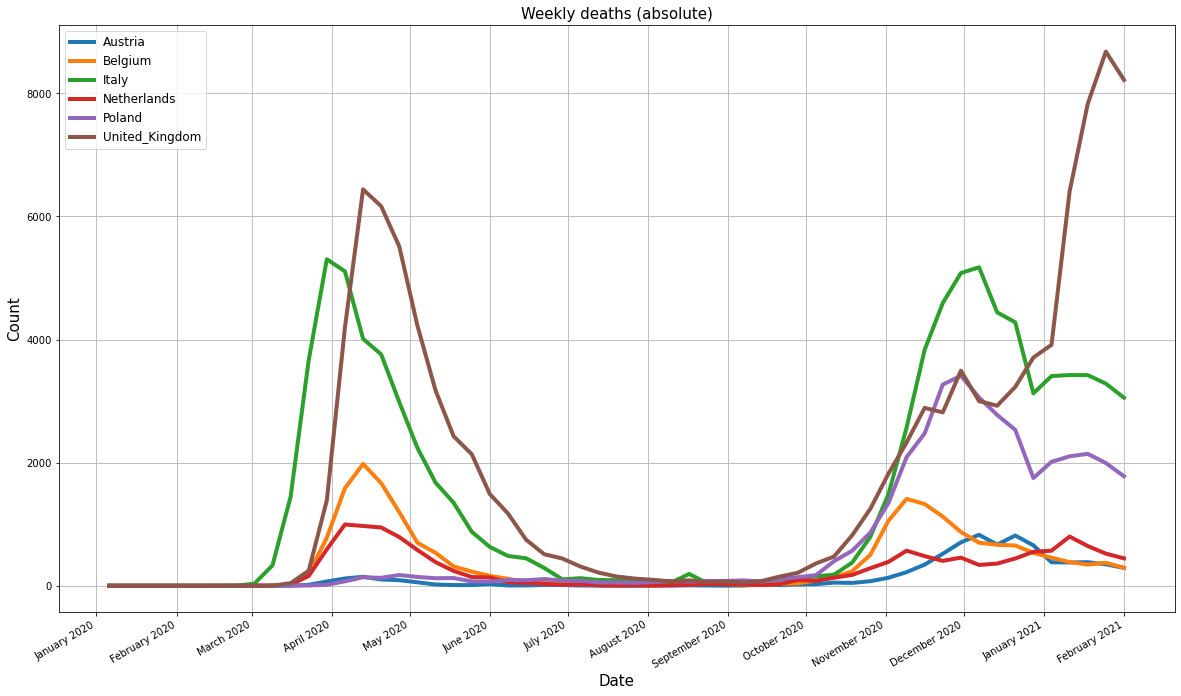

In [22]:
plt.rcParams["figure.figsize"] = [20,12]
for covid_df_country in covid_df_countries:
    lbl = next(iter(set(covid_df_country.country.values))) 
    x = [datetime.datetime.strptime(d,'%d %B %Y') for d in covid_df_country.date.values]
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    plt.plot(x, covid_df_country.deaths_weekly, alpha=1.0, label=lbl, linewidth=4.0)
    plt.gcf().autofmt_xdate()
    plt.legend(loc="upper left",  prop={'size': 12})
plt.grid()
plt.title('Weekly deaths (absolute)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)


#### Relative population

Text(0, 0.5, '%')

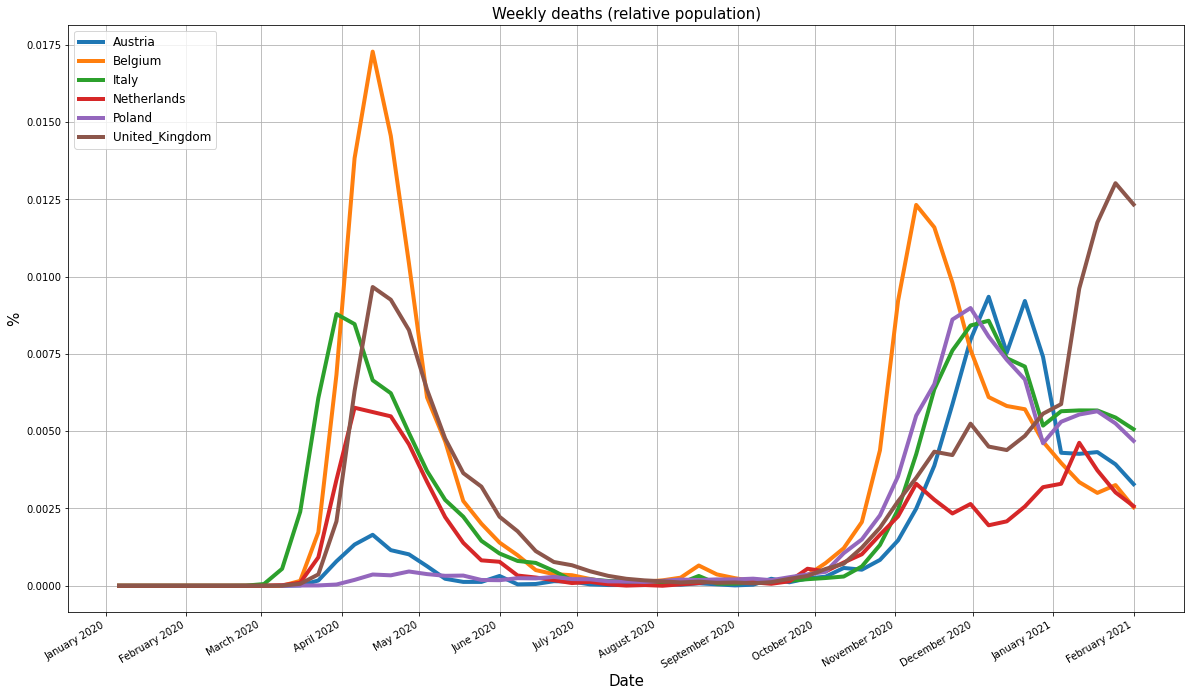

In [23]:
plt.rcParams["figure.figsize"] = [20,12]
for covid_df_country in covid_df_countries:
    lbl = next(iter(set(covid_df_country.country.values))) 
    x = [datetime.datetime.strptime(d,'%d %B %Y') for d in covid_df_country.date.values]
    y = covid_df_country.deaths_weekly / covid_df_country.population * 100
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    plt.plot(x, y, alpha=1.0, label=lbl, linewidth=4.0)
    plt.gcf().autofmt_xdate()
    plt.legend(loc="upper left", prop={'size': 12})
plt.grid()
plt.title('Weekly deaths (relative population)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('%', fontsize=15)


#### Cumulated

Text(0, 0.5, 'Count')

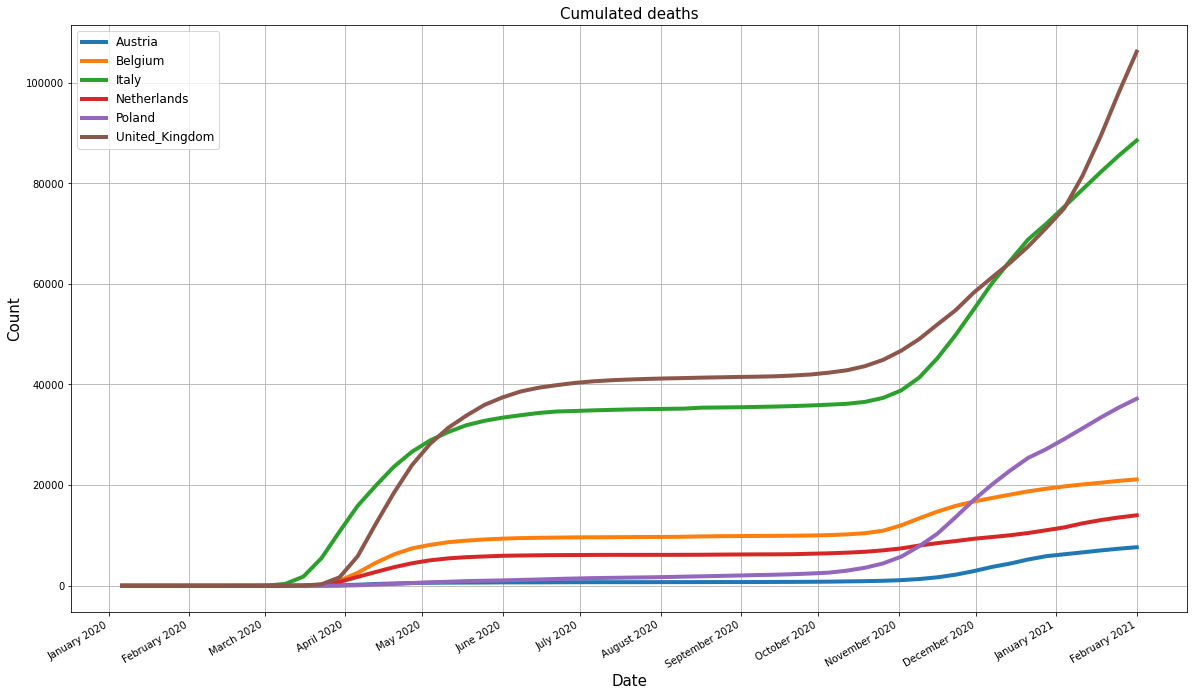

In [24]:
plt.rcParams["figure.figsize"] = [20,12]
for covid_df_country in covid_df_countries:
    lbl = next(iter(set(covid_df_country.country.values))) 
    x = [datetime.datetime.strptime(d,'%d %B %Y') for d in covid_df_country.date.values]
    covid_df_country['cumulativeDeaths']=covid_df_country.loc[::-1, 'deaths_weekly'].cumsum(axis = 0)[::-1]
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    plt.plot(x, covid_df_country['cumulativeDeaths'], alpha=1.0, label=lbl, linewidth=4.0)
    plt.gcf().autofmt_xdate()
    plt.legend(loc="upper left", prop={'size': 12})
plt.grid()
plt.title('Cumulated deaths', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)

#### Visualisation in Tableau Public
Of course changes in the Tableau Public dashboard are reflected below.

In [25]:
%%html
<div class='tableauPlaceholder' id='viz1612728645244' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Mo&#47;MortalilityrateCovid-19ECDC&#47;Deaths-Covid-19&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='MortalilityrateCovid-19ECDC&#47;Deaths-Covid-19' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Mo&#47;MortalilityrateCovid-19ECDC&#47;Deaths-Covid-19&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1612728645244');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='1727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>